In [1]:
## make plots inline - for ipython notebooks
%matplotlib inline

from numpy import linspace, sqrt, array, pi, cos, sin, dot, exp, sinh, log, log10, cosh, sinh
from numpy import atleast_1d, zeros, where, zeros_like
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
from pylab import loadtxt
from numpy.linalg import norm as norm
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from scipy import interpolate
import time
import math
import scipy.special as sp
from scipy import integrate
import matplotlib.ticker as ticker

import matplotlib
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
# Make use of TeX\ufeff
# rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})


# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=10)
rc('xtick', labelsize=16)
rc('ytick.major', size=5, pad=10)
rc('ytick', labelsize=16)

plt.rcParams['figure.dpi'] = 125
plt.rcParams['savefig.dpi'] = 300

pcolors=['SteelBlue','Indigo','FireBrick','Coral','Tan','OliveDrab']

In [2]:
# running CLASS once to get various background quantities
k = 1.e-4  # 1/Mpc
common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes',
                   'gauge':'newtonian'}  

M = Class()
M.set(common_settings)
M.compute()

derived = M.get_current_derived_parameters(['tau_rec','conformal_age','z_rec'])
thermo = M.get_thermodynamics()

z_rec = derived['z_rec']
tau_rec=derived['tau_rec']
tau_0=derived['conformal_age']
tau_0_minus_tau_rec_Mpc = (tau_0-tau_rec)
tau_reio=4255.316282

exp_kappa=thermo['exp(-kappa)']
tau = thermo['conf. time [Mpc]']
g = thermo['g [Mpc^-1]']

exp_kappa_func=interpolate.interp1d(tau,exp_kappa,kind='cubic')
g_func=interpolate.interp1d(tau,g,kind='cubic')

In [3]:
k_list=np.linspace(1.e-4,5.e-1,300) # change based on what k-space resolution you need, max=1000

#np.linspace(1.e-4,1.e-1,1000)
tau_list1=np.linspace(200,tau_rec,100) # change based on what tau-space resolution you need, max=100
tau_list2=np.linspace(tau_rec+1,1.e+3,300) # change based on what tau-space resolution you need, max=700
tau_list=np.concatenate((tau_list1,tau_list2))

tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum

In [4]:
# running CLASS for each k and storing phi, psi, theta etc. outputs in arrays

phi_list=[]
psi_list=[]
theta_list=[]

phi_prime_list=[]
psi_prime_list=[]

for k in k_list:
    M.empty()
    common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes', 
                   'gauge':'newtonian'} 
    M.set(common_settings)
    M.compute()
    all_k = M.get_perturbations()  
    one_k = all_k['scalar'][0]      
    tau_pert = one_k['tau [Mpc]']
    Theta0 = 0.25*one_k['delta_g']
    phi = one_k['phi']
    psi = one_k['psi']
    theta_b = one_k['theta_b']
    a = one_k['a']
    phi_func=interpolate.interp1d(tau_pert,phi,kind='cubic')
    psi_func=interpolate.interp1d(tau_pert,psi,kind='cubic')
    theta0_func=interpolate.interp1d(tau_pert,Theta0,kind='cubic')   
    
    phi_list.append(np.append(k,phi_func(tau_list))) # first index is the k value
    psi_list.append(np.append(k,psi_func(tau_list)))
    theta_list.append(np.append(k,theta0_func(tau_list)))    
    phi_prime_list.append(np.append(k,derivative(phi_func,tau_list,dx=0.1)))
    psi_prime_list.append(np.append(k,derivative(psi_func,tau_list,dx=0.1)))
    

In [5]:
## 99th entry gives tau_rec
tau_list[99]-tau_rec

0.0

In [6]:
tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum
k_diff_list=k_list[1:len(k_list)]-k_list[0:len(k_list)-1] # k difference array needed to compute Riemann sum

def func(x): # defines the curvature perturbation in momentum space
    return sp.sici(x)[0]-np.sin(x) #sici returns {si(x), ci(x)} as tuples

phidot=59**2
g=1
prefac=-g/phidot*(4*np.pi)/(2*np.pi)**3*2.7*1.e+6

### ISW Transfer function, need to evaluate only once

In [7]:
# ISW transfer function, f_ISW(k,l) in the draft

f_ISW = np.zeros_like(k_list)

for ell in np.arange(1,600):
    sum_over_k = []
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        sum_over_k.append(integral_time)
    f_ISW = np.vstack((f_ISW, sum_over_k))
        

### SW Transfer function, need to evaluate only once

In [8]:
# SW transfer function, f_SW(k,l) in the draft

f_SW = np.zeros_like(k_list)

for ell in np.arange(1, 2000):
    sum_over_k_SW = [] 
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time_SW = (psi_list[n][99]+theta_list[n][99])*sp.spherical_jn(ell,k_val*(tau_0-tau_rec)) ## 99 implies evaluation at tau_rec
        sum_over_k_SW.append(integrand_time_SW)
    f_SW = np.vstack((f_SW, sum_over_k_SW))


### ISW for single eta_HS

In [9]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=50


integrand_list=[]
ell_count=1
for ell in np.arange(1,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
    ell_count += 1

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 0.3516140545755999


### SW for single eta_HS

In [10]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
eta_HS = tau_rec

etap=50


integrand_list=[]
ell_count=1
for ell in np.arange(1,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]        
        integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
    ell_count +=1

print('the SW amplitude is',np.sum(integrand_list))

the SW amplitude is 5.156139133009607


### Central temperature scan for different eta_HS, ISW piece

In [11]:
tau_rec

280.62745874925827

In [12]:
etap=50


ISW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,600):
        sum_over_k=[]
        for n in range(len(k_list)): # loops over all k values for each ell
            k_val=psi_prime_list[n][0] # first value gives the k
            integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
            sum_over_k.append(integrand_full) 
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
        ell_count += 1
    print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  
    ISW_central_list.append(np.sum(integrand_list))

the ISW amplitude is 0.1545356606494374
the ISW amplitude is 0.15857953842009215
the ISW amplitude is 0.16281549776378537
the ISW amplitude is 0.1672820709508538
the ISW amplitude is 0.17201610664702002
the ISW amplitude is 0.1770523040238694
the ISW amplitude is 0.1824228191549087
the ISW amplitude is 0.1881568486269825
the ISW amplitude is 0.19428012804077846
the ISW amplitude is 0.2008143621597564
the ISW amplitude is 0.20777666123701788
the ISW amplitude is 0.21517904933832205
the ISW amplitude is 0.22302805138582643
the ISW amplitude is 0.231324317659717
the ISW amplitude is 0.24006225739322928
the ISW amplitude is 0.2492297176596244
the ISW amplitude is 0.2588077981361865
the ISW amplitude is 0.26877087860093374
the ISW amplitude is 0.2790868568997893
the ISW amplitude is 0.289717517854569
the ISW amplitude is 0.30061895290953367
the ISW amplitude is 0.3117420380431941
the ISW amplitude is 0.3230330822119827
the ISW amplitude is 0.3344347791868331
the ISW amplitude is 0.345887487

### Central temperature scan for different eta_HS, SW piece

In [13]:
etap=50

SW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,2000):
        sum_over_k=[]
        for n in range(len(k_list)):
            k_val=psi_prime_list[n][0]        
            integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
            sum_over_k.append(integrand_full)
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
        ell_count +=1
    print('the SW amplitude is',np.sum(integrand_list))
    SW_central_list.append(np.sum(integrand_list))

the SW amplitude is 0.27633680470530164
the SW amplitude is 0.41611391142802967
the SW amplitude is 0.5728393297549867
the SW amplitude is 0.746003627390279
the SW amplitude is 0.9336900968562989
the SW amplitude is 1.133446650582263
the SW amplitude is 1.3431818115590373
the SW amplitude is 1.5615494156582297
the SW amplitude is 1.7877132360044974
the SW amplitude is 2.0208455181210843
the SW amplitude is 2.2598427443927873
the SW amplitude is 2.503454839139615
the SW amplitude is 2.750593078730143
the SW amplitude is 3.0003988957142558
the SW amplitude is 3.2518864528004277
the SW amplitude is 3.5034025572377994
the SW amplitude is 3.7523662811197873
the SW amplitude is 3.9955186931081252
the SW amplitude is 4.229403206463342
the SW amplitude is 4.450475136882041
the SW amplitude is 4.654465791808105
the SW amplitude is 4.835310017160772
the SW amplitude is 4.984559001189932
the SW amplitude is 5.092179969976157
the SW amplitude is 5.148871073204155
the SW amplitude is 5.148971006509

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


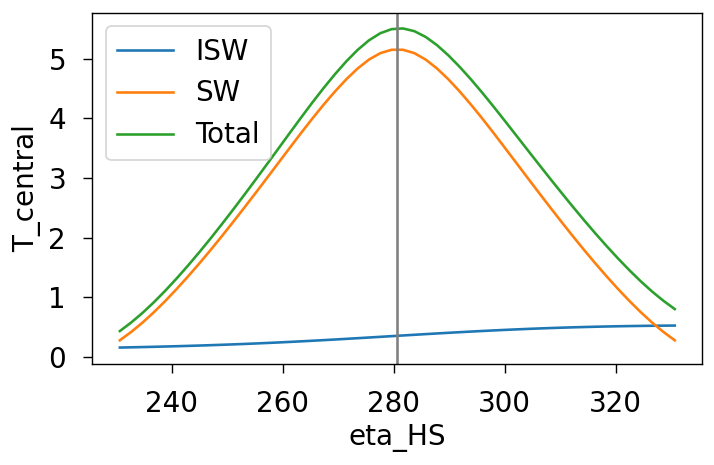

In [14]:
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), ISW_central_list, label='ISW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), SW_central_list, label='SW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), np.array(SW_central_list)+np.array(ISW_central_list), label='Total')
plt.xlabel('eta_HS')
plt.ylabel('T_central')
plt.legend()
plt.axvline(x=tau_rec, color='gray')
plt.tight_layout()
plt.savefig('eta50_central_temp.pdf')

In [25]:
np.logspace(-4.0, -1.0, num=1)

array([0.0001])

### Temperature angular profilescan for different \eta_HS, SW piece

In [15]:
etap=50

eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

SW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    print(eta_HS)
    SW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,2000): 
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        SW_angle_temp.append(np.sum(integrand_list))
        
    SW_angle_arr = np.vstack((SW_angle_arr, SW_angle_temp))
    np.savetxt('SW_stack_eta50.txt', SW_angle_arr)

230.62745874925827
232.66827507578887
234.7090914023195
236.7499077288501
238.7907240553807
240.83154038191134
242.87235670844194
244.91317303497254
246.95398936150318
248.99480568803378
251.03562201456438
253.076438341095
255.11725466762562
257.1580709941562
259.1988873206868
261.2397036472174
263.2805199737481
265.3213363002787
267.3621526268093
269.4029689533399
271.4437852798705
273.48460160640116
275.52541793293176
277.56623425946236
279.60705058599297
281.64786691252357
283.68868323905417
285.7294995655848
287.77031589211543
289.81113221864604
291.85194854517664
293.89276487170724
295.93358119823785
297.9743975247685
300.0152138512991
302.0560301778297
304.0968465043603
306.1376628308909
308.1784791574215
310.2192954839521
312.2601118104827
314.3009281370134
316.341744463544
318.3825607900746
320.4233771166052
322.46419344313585
324.50500976966646
326.54582609619706
328.58664242272766
330.62745874925827


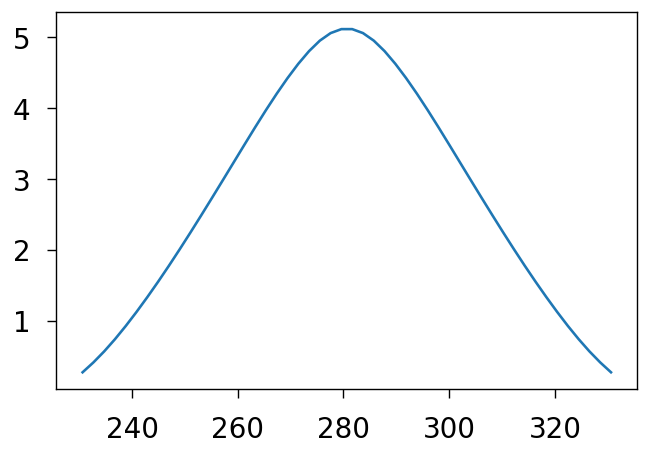

In [16]:
plt.plot(eta_HS_arr, SW_angle_arr.T[0][1:])

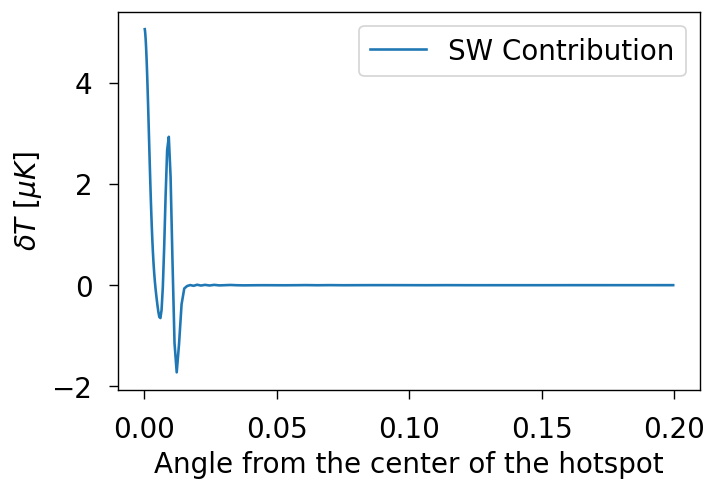

In [17]:
plt.plot(ang_arr, SW_angle_arr[24], label='SW Contribution')
#plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

### Temperature angular profilescan for different \eta_HS, ISW piece

In [18]:
etap=50

eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

ISW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr = np.vstack((ISW_angle_arr, ISW_angle_temp))

In [21]:
np.savetxt('ISW_stack_eta50.txt', ISW_angle_arr)

In [33]:
ISW_angle_arr = np.loadtxt('../ISW_stack.txt')

In [31]:
ISW_angle_arr = np.loadtxt('ISW_stack_eta100.txt')

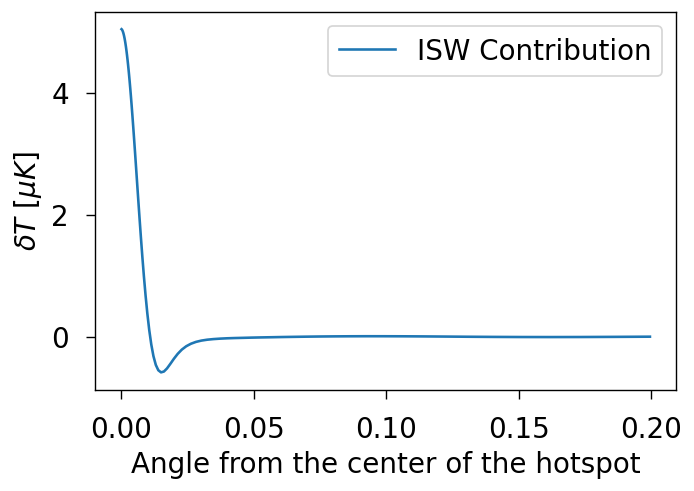

In [34]:
ang_arr = np.logspace(-3.7, -0.7, num=100)
plt.plot(ang_arr, ISW_angle_arr[24], label='ISW Contribution')
#plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

In [28]:
eta_HS_arr[24]

277.3621526268093

# Old

In [52]:
etap=160
eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 5)
ang_arr = np.linspace(0.07, 0.2, num=10)

ISW_angle_arr_n=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr_n = np.vstack((ISW_angle_arr_n, ISW_angle_temp))

In [45]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=160
integrand_list=[]
for ell in np.arange(20,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 5.611001349298974


In [11]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
etap=160
integrand_list=[]
for ell in np.arange(20,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]
        integrand_time=g_func(tau_list)*(psi_list[n][1:len(tau_list)+1]+theta_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list))
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list)
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))

print('the SW amplitude is',np.sum(integrand_list))    

the SW amplitude is 28.663737220837334
